In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import scipy
from sklearn.metrics import classification_report
pd.set_option("display.max_columns",25)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.ensemble import VotingClassifier
from pandas.plotting import andrews_curves
from pandas.plotting import parallel_coordinates
plt.style.use('ggplot')

# Data Preprocessing

In [21]:
df = pd.read_csv("ens_test.csv").drop_duplicates().reset_index(drop=True)
df.head()

,Y,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,VAR8,VAR9
0,No,19,182,Black,No,0,No,Yes,0,2523
1,No,33,155,Other,No,0,No,No,3,2551
2,No,20,105,White,Yes,0,No,No,1,2557
3,No,21,108,White,Yes,0,No,Yes,2,2594
4,No,18,107,White,Yes,0,No,Yes,0,2600


In [22]:
df.shape

(184, 10)

## Check whether classes are balanced

In [23]:
df.groupby('Y').size()

Y
No     125
Yes     59
dtype: int64

## (We will balance the classes before training)

In [24]:
print(df['Y'].unique())

['No' 'Yes']


In [25]:
df['Y'] = np.where(df['Y']=='Yes', 1, 0)

In [27]:
print(len(df['VAR1'].unique()), len(df['VAR2'].unique()), len(df['VAR3'].unique()), len(df['VAR4'].unique()))

24 75 3 2


In [28]:
print(len(df['VAR5'].unique()), len(df['VAR6'].unique()), len(df['VAR7'].unique()), len(df['VAR8'].unique()))

4 2 2 6


In [29]:
print(len(df['VAR9'].unique()))

131


## From visual inspection above, s9 seems like an identifier column

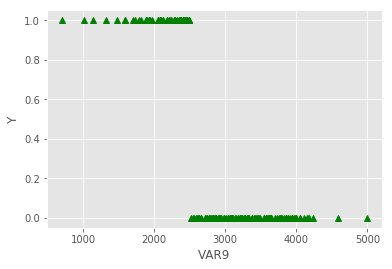

In [30]:
plt.plot(df['VAR9'], df['Y'], 'g^')
plt.grid(True)
plt.xlabel('VAR9')
plt.ylabel('Y')
plt.show()

### As can be seen above, VAR9 splits the data to the 'Yes' and 'No' labels simply by range. We will have to check with business about the meaning of column VAR9.
### If we use VAR9 in training, we will not learn anything about the data as the model will just use that one column to predict response. Hence we will drop VAR9 from our feature set and proceed with training
### Some VAR9s are repeated in data, however, they correspond to same response

In [31]:
dfVAR9=df.groupby("VAR9").size().reset_index(name="VAR9C") 
dfVAR9C = df.merge(dfVAR9, on='VAR9')
dfVAR9C[dfVAR9C['VAR9C']>1].head(9)

,Y,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,VAR8,VAR9,VAR9C
6,0,22,118,White,No,0,No,No,1,2637,2
7,0,17,103,Other,No,0,No,No,1,2637,2
19,0,32,121,Other,No,0,No,No,2,2835,2
20,0,31,100,White,No,0,No,Yes,3,2835,2
23,0,25,120,Other,No,0,No,Yes,2,2877,2
24,0,28,167,White,No,0,No,No,0,2877,2
26,0,29,150,White,No,0,No,No,2,2920,3
27,0,26,168,Black,Yes,0,No,No,0,2920,3
28,0,17,113,Black,No,0,No,No,1,2920,3


In [32]:
df.drop('VAR9',1,inplace=True)

### Next we will examine the numeric columns VAR1, VAR2 for outliers

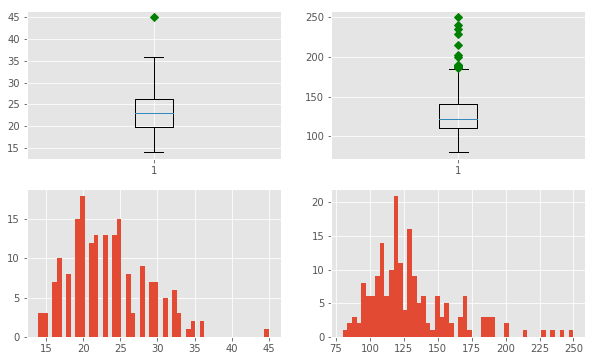

In [33]:
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(10, 6))

ax1.boxplot(df['VAR1'], 0, 'gD')
ax2.boxplot(df['VAR2'], 0, 'gD')
ax3.hist(df['VAR1'],50)
ax4.hist(df['VAR2'],50);

In [34]:
lvar1,hvar1 = np.mean(df['VAR1'])-3*np.std(df['VAR1']), np.mean(df['VAR1'])+3*np.std(df['VAR1'])
print(lvar1,hvar1)
print(min(df['VAR1']),max(df['VAR1']))

7.5551706209423095 39.216568509492475
14 45


In [35]:
df[df['VAR1']>hvar1]

,Y,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,VAR8
124,0,45,123,White,No,0,No,No,1


In [36]:
lvar2,hvar2 = np.mean(df['VAR2'])-3*np.std(df['VAR2']), np.mean(df['VAR2'])+3*np.std(df['VAR2'])
print(lvar2,hvar2)
print(min(df['VAR2']),max(df['VAR2']))

38.36897757094398 222.13102242905603
80 250


In [37]:
df[df['VAR2']>hvar2]

,Y,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,VAR8
63,0,28,250,Other,Yes,0,No,No,6
71,0,18,229,Black,No,0,No,No,0
88,0,19,235,White,Yes,0,Yes,No,0
100,0,25,241,Black,No,0,Yes,No,0


### As there are some outliers in the data, but not significant, we will later scale with StandardScaler (instead of RobustScaler)

### VAR5 and VAR8 can be converted to categorial, since they only take a few values. Need to check with business whether these are the only possible values

In [38]:
#df = df[df['VAR1']!=max(df['VAR1'])].reset_index(drop=True)

In [39]:
print(df['VAR5'].unique(), df['VAR8'].unique())

[0 1 2 3] [0 3 1 2 4 6]


### Now we will convert all categorical columns to one hot

In [40]:
cols_to_transform = [ 'VAR3', 'VAR4','VAR5','VAR6', 'VAR7','VAR8' ]
df_with_dummies = pd.get_dummies(df,columns = cols_to_transform )

In [41]:
df_with_dummies.head(10)

,Y,VAR1,VAR2,VAR3_Black,VAR3_Other,VAR3_White,VAR4_No,VAR4_Yes,VAR5_0,VAR5_1,VAR5_2,VAR5_3,VAR6_No,VAR6_Yes,VAR7_No,VAR7_Yes,VAR8_0,VAR8_1,VAR8_2,VAR8_3,VAR8_4,VAR8_6
0,0,19,182,1,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0
1,0,33,155,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0
2,0,20,105,0,0,1,0,1,1,0,0,0,1,0,1,0,0,1,0,0,0,0
3,0,21,108,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0
4,0,18,107,0,0,1,0,1,1,0,0,0,1,0,0,1,1,0,0,0,0,0
5,0,21,124,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0
6,0,22,118,0,0,1,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0
7,0,17,103,0,1,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0
8,0,29,123,0,0,1,0,1,1,0,0,0,1,0,1,0,0,1,0,0,0,0
9,0,26,113,0,0,1,0,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0


In [42]:
#df_with_dummies = df_with_dummies.sample(frac=1, random_state=123).reset_index(drop=True)

In [45]:
X,y = df_with_dummies.drop('Y', axis=1),df_with_dummies['Y']

### Next we will check whether the classes are seperable by features. As seen below, the feature values do show some, but not a significant level of clustering

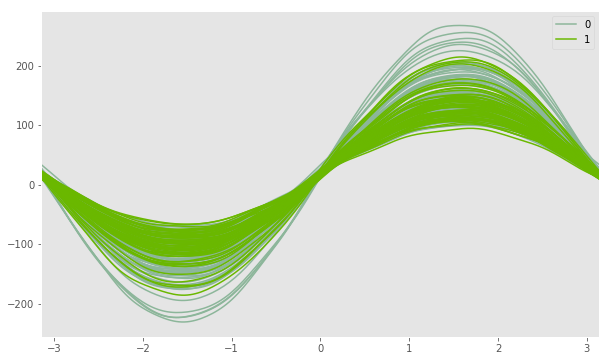

In [46]:
plt.figure(figsize=(10, 6))
andrews_curves(df_with_dummies, 'Y');


### We will use Satandard Scaler for VAR1 and VAR2

In [49]:
xn = pd.DataFrame(StandardScaler().fit_transform(X[['VAR1','VAR2']]), columns=['VAR1','VAR2']);

C:\Users\rajde\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\rajde\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [50]:
X_scaled = pd.DataFrame(X)
X_scaled.loc[:,['VAR1', 'VAR2']] = xn

### Create the training and test sets

In [51]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled,
                                                  y,
                                                  test_size = .1,
                                                  random_state=123)

In [52]:
Counter(y_train)

Counter({1: 55, 0: 110})

In [28]:
#diffclassses = Counter(y_train)[0] - Counter(y_train)[1]
#ones_train = x_train.sample(diffclassses,random_state=123)
#x_train_res = pd.concat([x_train, ones_train], ignore_index=True)
#y_train_res=pd.concat([y_train, pd.Series(np.ones(diffclassses),dtype=int)], ignore_index=True)

### Since we saw above that the classes were imbalanced, we will resample the data using SMOTE

In [53]:
sm = SMOTE(random_state=123)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

In [54]:
Counter(y_train_res)

Counter({1: 110, 0: 110})

In [55]:
x_train_res = pd.DataFrame(x_train_res, columns=x_train.columns)

### At this point we have completed our data pre-processing steps and ready for training our model

# Model Training

### Logistic regression, tree based models or SVM are all suitable for small dataset binary classification problems

### We will start with SVM

In [56]:
# Find the best parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [5e-1, 1e-1, 1e-2, 1e-3],'C': [1, 10, 100]},
                    {'kernel': ['linear'], 'C': [1, 10, 100]}]

In [57]:
#We make sure that the k-folds are balanced using StratifiedKFold
cv = StratifiedKFold(n_splits=10, random_state=123)
sclf = GridSearchCV(svm.SVC(random_state=123), tuned_parameters, cv=cv, scoring='roc_auc')

In [58]:
sclf.fit(x_train_res, y_train_res)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=False),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=123,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kernel': ['rbf'], 'gamma': [0.5, 0.1, 0.01, 0.001], 'C': [1, 10, 100]}, {'kernel': ['linear'], 'C': [1, 10, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [59]:
print("Best parameters set found on training set:")
print(sclf.best_params_)

Best parameters set found on training set:
{'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}


In [60]:
#pd.DataFrame.from_dict(sclf.cv_results_)

In [61]:
y_pred = sclf.predict(x_test)
print(classification_report(y_test, y_pred))
print("Accuracy:",accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.33      0.25      0.29         4

   micro avg       0.74      0.74      0.74        19
   macro avg       0.57      0.56      0.56        19
weighted avg       0.71      0.74      0.72        19

Accuracy: 0.7368421052631579


### Next we will try XGBoost

In [62]:
cv_params = {
     'nthread':[4],
     'objective':['binary:logistic'],
     'n_estimators':[31,51],
     'max_depth':[4,5,6],
     'min_child_weight':[0.5,1,2],
     'colsample_bytree':[0.05, 0.1,0.2],
     'colsample_bylevel':[0.1,0.2],
     'subsample': [0.8,0.9],
     'silent': [1],
     'seed':[123]
}

cv = StratifiedKFold(n_splits=10, random_state=123)
optimized_GBM = GridSearchCV(xgb.XGBClassifier(random_state=123), 
                            cv_params, cv = cv, n_jobs=-1, scoring='roc_auc')

In [63]:
optimized_GBM.fit(x_train_res, y_train_res)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=False),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'nthread': [4], 'objective': ['binary:logistic'], 'n_estimators': [31, 51], 'max_depth': [4, 5, 6], 'min_child_weight': [0.5, 1, 2], 'colsample_bytree': [0.05, 0.1, 0.2], 'colsample_bylevel': [0.1, 0.2], 'subsample': [0.8, 0.9], 'silent': [1], 'seed': [123]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [64]:
optimized_GBM.best_params_

{'colsample_bylevel': 0.1,
 'colsample_bytree': 0.1,
 'max_depth': 4,
 'min_child_weight': 0.5,
 'n_estimators': 31,
 'nthread': 4,
 'objective': 'binary:logistic',
 'seed': 123,
 'silent': 1,
 'subsample': 0.8}

In [65]:
y_pred = optimized_GBM.predict(x_test)
print(classification_report(y_test, y_pred))
print("Accuracy:",accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.67      0.74        15
           1       0.29      0.50      0.36         4

   micro avg       0.63      0.63      0.63        19
   macro avg       0.56      0.58      0.55        19
weighted avg       0.72      0.63      0.66        19

Accuracy: 0.631578947368421


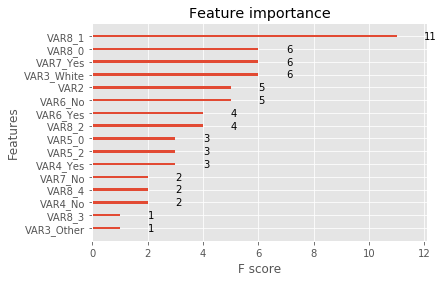

In [66]:
plot_importance(optimized_GBM.best_estimator_);

## Finally Logistic Regression

In [67]:
grid = {'C': [1,10,100,1000,10000], 'solver':['newton-cg', 'liblinear'], 'tol':[0.05,0.1,0.5,1.0]}


cv = StratifiedKFold(n_splits=10, random_state=123)
lclf = LogisticRegression(penalty='l2', random_state=123)
gs = GridSearchCV(lclf, grid, cv=cv, scoring='roc_auc')

In [68]:
gs.fit(x_train_res, y_train_res)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=False),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=123, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1, 10, 100, 1000, 10000], 'solver': ['newton-cg', 'liblinear'], 'tol': [0.05, 0.1, 0.5, 1.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [69]:
gs.best_params_

{'C': 1, 'solver': 'liblinear', 'tol': 0.1}

In [70]:
y_pred = gs.predict(x_test)
print(classification_report(y_test, y_pred))
print("Accuracy:",accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.73      0.85        15
           1       0.50      1.00      0.67         4

   micro avg       0.79      0.79      0.79        19
   macro avg       0.75      0.87      0.76        19
weighted avg       0.89      0.79      0.81        19

Accuracy: 0.7894736842105263


In [71]:
eclf1 = VotingClassifier(estimators=[('svc', sclf.best_estimator_),\
                                     ('xgb', optimized_GBM.best_estimator_),\
                                     ('lr', gs.best_estimator_)], voting='hard')

In [72]:
eclf1 = eclf1.fit(x_train_res, y_train_res)

In [73]:
y_pred = eclf1.predict(x_test)
print(classification_report(y_test, y_pred))
print("Accuracy:",accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.73      0.79        15
           1       0.33      0.50      0.40         4

   micro avg       0.68      0.68      0.68        19
   macro avg       0.59      0.62      0.59        19
weighted avg       0.74      0.68      0.70        19

Accuracy: 0.6842105263157895
